In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
data_folder = "data_10images_250by250pixels_upto20pins_4seed"
d1 = 250
d2 = 250

In [3]:
pins_file = f"{data_folder}/pins.csv"
pins_df = pd.read_csv(pins_file)
pins_df

,image,pins,outputs
0,0.png,"[(13, 29), (129, 16), (88, 229), (60, 115), (1...","[13.728903294623969, 10.575606719070057, 2.122..."
1,1.png,"[(38, 24), (137, 196), (37, 103), (162, 133), ...","[13.322547887001559, 13.322547881681377, 13.32..."
2,2.png,"[(112, 151), (168, 57), (88, 15), (61, 32), (1...","[9.830720575465174, 11.601993545667812, 12.202..."
3,3.png,"[(202, 243), (237, 3), (239, 216), (144, 196),...","[49.55928726686623, 36.96401043523207, 56.2967..."
4,4.png,"[(25, 111), (166, 131), (170, 71), (61, 206), ...","[23.982078583135237, 30.707864528264178, 25.15..."
5,5.png,"[(31, 54), (39, 158), (64, 52), (159, 163), (2...","[35.27717117776169, 35.2771712055689, 35.27717..."
6,6.png,"[(105, 200), (214, 220), (173, 135), (90, 168)...","[22.463345390978386, 18.079033563946975, 31.32..."
7,7.png,"[(158, 136), (249, 232), (32, 180), (203, 81),...","[35.178246465062855, 17.1409087706873, 25.7463..."
8,8.png,"[(0, 202), (69, 71), (181, 151), (11, 162), (1...","[28.73562711963268, 9.661732021832213, -9.7906..."
9,9.png,"[(202, 180), (189, 121), (231, 114), (104, 245...","[10.889820212812102, 3.8350533782894067, 11.52..."


In [4]:
# y_file = f"{data_folder}/y.csv"
# out_df = pd.read_csv(y_file)
# out_df

In [5]:
img_name = pins_df.iloc[4, 0]
pins = eval(pins_df.iloc[4, 1])
pins = np.asarray(pins)
pins

array([[ 25, 111],
       [166, 131],
       [170,  71],
       [ 61, 206],
       [169,  12],
       [ 94, 135],
       [122,  81],
       [ 18,  86],
       [174, 111],
       [249,  80],
       [142, 207],
       [234,  64],
       [ 97,  10],
       [ 11, 159]])

In [6]:
outputs = eval(pins_df.iloc[4, 2])
outputs = np.asarray(outputs)
outputs

array([23.98207858, 30.70786453, 25.15204023, 22.03983165, 27.72274812,
       21.98761079, 23.04792492, 27.24487696, 29.04503996, 20.69129976,
       30.76032468,  3.25479396, 18.21897674, 28.6233152 ])

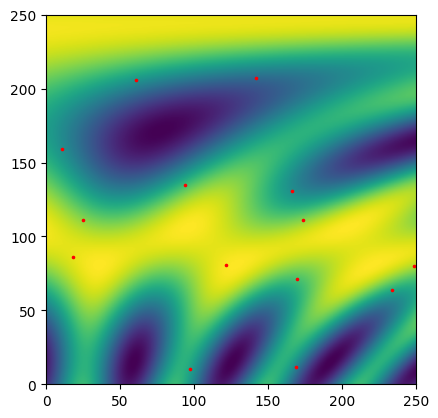

In [7]:
def show_pins(image, pins, outputs):
    """Show image with pins"""
    plt.imshow(image, extent=[0,250,0,250])
    plt.scatter(pins[:, 0], pins[:, 1], s=10, marker='.', c='r')
    # plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_pins(io.imread(f"{data_folder}/images/{img_name}"), pins, outputs)
plt.show()

In [8]:
class SynthHeatmapDataset(Dataset):
    """Synthetic Heatmaps dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pins_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pins_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.pins_frame.iloc[idx, 0])
        image = io.imread(img_name)
        pins = np.asarray(eval(self.pins_frame.iloc[idx, 1]))
        outputs = np.asarray(eval(self.pins_frame.iloc[idx, 2]))

        sample = {'image': image, 'pins': pins, 'outputs': outputs}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (539, 539, 4) (6, 2)
1 (539, 539, 4) (8, 2)
2 (539, 539, 4) (16, 2)
3 (539, 539, 4) (11, 2)


/tmp/ipykernel_215389/2313139159.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


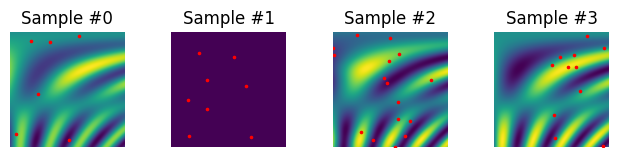

In [9]:
heatmap_dataset = SynthHeatmapDataset(csv_file=f"{data_folder}/pins.csv",
                                      root_dir=f"{data_folder}/images/")

fig = plt.figure()

for i, sample in enumerate(heatmap_dataset):
    print(i, sample['image'].shape, sample['pins'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pins(**sample)

    if i == 3:
        plt.show()
        break

In [10]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, pins, outputs = sample['image'], sample['pins'], sample['outputs']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'pins': torch.from_numpy(pins),
                'outputs': torch.from_numpy(outputs)}

In [11]:
transformed_dataset = SynthHeatmapDataset(csv_file=f"{data_folder}/pins.csv",
                                          root_dir=f"{data_folder}/images/",
                                          transform=transforms.Compose([ToTensor()])
                                         )

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['pins'].size(), sample['outputs'].size())

    if i == 3:
        break

0 torch.Size([4, 539, 539]) torch.Size([6, 2]) torch.Size([6])
1 torch.Size([4, 539, 539]) torch.Size([8, 2]) torch.Size([8])
2 torch.Size([4, 539, 539]) torch.Size([16, 2]) torch.Size([16])
3 torch.Size([4, 539, 539]) torch.Size([11, 2]) torch.Size([11])
